In [181]:
!which python

/home/quirin/mambaforge/envs/ppi/bin/python


In [182]:
from pathlib import Path

import sys
import tqdm
import json
import pandas as pd
import numpy as np

In [183]:
home = Path('/home/quirin/PYTHON') if 'kaindl' not in sys.executable else Path('/mnt/project/kaindl')
home

PosixPath('/home/quirin/PYTHON')

In [ ]:
# run SETH
#%env HOME=/mnt/project/kaindl
!bash "$HOME/SETH/seth.sh"

In [ ]:
# extract pDockQ, iptm and ptm values
!python3 "$HOME/FoldDock/leo_pdockq.py"

In [184]:
# combine with PPI labels
ppi_dir = home / 'ppi/ppi_data/v2.1/1:1_small'

ppis = pd.read_csv(ppi_dir / 'huri_test.tsv', sep='\t')[
    ['hash_A', 'hash_B', 'label']].rename(columns=dict(
    hash_A='ida', hash_B='idb'))
ppis.head()

,ida,idb,label
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1
2,CRC-001576EA78C61C85,CRC-2743716544288776,1
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1


In [185]:
pdockqs = pd.read_csv(
    home / 'FoldDock/leo_ppi_huri_test/pdockqs.tsv', sep='\t')
print(len(pdockqs))
pdockqs.head()

1030


,index,ida,idb,lena,lenb,chunk,label,model,ptm,iptm,pdockq,ppv
0,0,CRC-4341E55D03D7B0E0,CRC-E0946B0FA7BD8109,520,179,1,0,2,0.43,0.09,0.000000,0.000000
1,1,CRC-43DAEB652A6B50B4,CRC-E315FD5587776211,183,297,1,0,2,0.66,0.55,0.217307,0.759412
2,2,CRC-44AD1817D6C536D6,CRC-541FBB6326C9C0BB,135,156,1,0,3,0.50,0.13,0.054291,0.635554
3,3,CRC-44AD1817D6C536D6,CRC-B62134DD1BEB636B,135,291,1,0,4,0.30,0.07,0.000000,0.000000
4,4,CRC-44AD1817D6C536D6,CRC-B6CEAC98EFB0D6C8,135,227,1,0,2,0.62,0.19,0.070013,0.667285


In [186]:
mp = pd.merge(ppis, pdockqs, on=['ida', 'idb', 'label'])
print(len(mp))
mp.head()

1030


,ida,idb,label,index,lena,lenb,chunk,model,ptm,iptm,pdockq,ppv
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1,0,230,460,5,4,0.64,0.43,0.338790,0.833678
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1,1,230,351,5,2,0.27,0.08,0.044733,0.635554
2,CRC-001576EA78C61C85,CRC-2743716544288776,1,2,230,137,5,4,0.42,0.41,0.051711,0.635554
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1,3,230,478,5,5,0.26,0.09,0.000000,0.000000
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1,4,230,723,5,2,0.43,0.11,0.000000,0.000000


### add SETH scores

In [187]:
with (home / 'FoldDock/leo_ppi_huri_test/'
             'seth_scores.json').open('r') as json_file:
    seth_scores = json.load(json_file)
_id = next(iter(seth_scores.keys()))
_id, len(seth_scores)

('CRC-A852B9063D29399D', 430)

In [188]:
seth_scores[_id].keys()

dict_keys(['seq', 'diso_pred', 'confidence', 'zscores'])

In [189]:
# calculate the average per-protein ChiZod-score
for _char in 'ab':
    mp[f'z{_char}'] = mp[f'id{_char}'].apply(lambda ida: np.array(
        spreds[ida]['zscores']).mean())
for _char in 'ab':
    mp[f'd{_char}'] = mp[f'id{_char}'].apply(lambda ida: np.array(
        spreds[ida]['diso_pred']).mean())
mp.head()

,ida,idb,label,index,lena,lenb,chunk,model,ptm,iptm,pdockq,ppv,za,zb,da,db
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1,0,230,460,5,4,0.64,0.43,0.338790,0.833678,6.533676,10.537396,0.591304,0.182609
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1,1,230,351,5,2,0.27,0.08,0.044733,0.635554,6.533676,8.990527,0.591304,0.307692
2,CRC-001576EA78C61C85,CRC-2743716544288776,1,2,230,137,5,4,0.42,0.41,0.051711,0.635554,6.533676,10.560456,0.591304,0.357664
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1,3,230,478,5,5,0.26,0.09,0.000000,0.000000,6.533676,11.606744,0.591304,0.094142
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1,4,230,723,5,2,0.43,0.11,0.000000,0.000000,6.533676,9.997539,0.591304,0.304288


### add `M0` and `M0x` predictions

In [190]:
m0x = pd.read_csv(ppi_dir / 'huri_test_preds.tsv',
                  sep='\t', header=0)
m0x.head()

,ida,idb,species,label,cclass,dscdsc__epoch10,baldsc__epoch01
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,9606,1,3,0.000883,0.003954
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,9606,1,3,0.000869,0.003952
2,CRC-001576EA78C61C85,CRC-2743716544288776,9606,1,3,0.000916,0.004022
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,9606,1,3,0.000879,0.003926
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,9606,1,3,0.001181,0.003942


In [191]:
m0x = m0x[['ida', 'idb', 'dscdsc__epoch10', 'baldsc__epoch01']].copy()
m0x.columns = ['ida', 'idb', 'M0', 'M0x']
m0x.head()

,ida,idb,M0,M0x
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,0.000883,0.003954
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,0.000869,0.003952
2,CRC-001576EA78C61C85,CRC-2743716544288776,0.000916,0.004022
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,0.000879,0.003926
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,0.001181,0.003942


**BUT** we don't know if this is just `C1` performance!
#### run uniqueprot2D

In [192]:
from ppi_utils.pairs import make_c_classes
from ppi_utils.general import run_uniqueprot2D

In [193]:
!which rostclust

/home/quirin/mambaforge/envs/ppi/bin/rostclust


In [194]:
train_fasta = home / 'D-SCRIPT/data/seqs/human_train_balanced.fa'
train_fasta.is_file()

True

In [195]:
run_uniqueprot2D(ppi_dir / 'huri_test.fasta',
                 train_fasta,
                 ppi_dir / 'huri_test_M0x_C3.fasta',
                 home / 'D-SCRIPT/data/hval_config.json')

rostclust uniqueprot2d --hval-config-path /home/quirin/PYTHON/D-SCRIPT/data/hval_config.json /home/quirin/PYTHON/ppi/ppi_data/v2.1/1:1_small/huri_test.fasta /home/quirin/PYTHON/D-SCRIPT/data/seqs/human_train_balanced.fa /home/quirin/PYTHON/ppi/ppi_data/v2.1/1:1_small/huri_test_M0x_C3.fasta
generate alignments: 100%|██████████| 1/1 [00:13<00:00, 13.99s/it]
163::7545 non-redundant in /home/quirin/PYTHON/ppi/ppi_data/v2.1/1:1_small/huri_test.fasta against /home/quirin/PYTHON/D-SCRIPT/data/seqs/human_train_balanced.fa written to /home/quirin/PYTHON/ppi/ppi_data/v2.1/1:1_small/huri_test_M0x_C3.fasta


In [196]:
test_pairs = make_c_classes(ppi_dir / 'huri_test.tsv', ppi_dir / 'huri_test_M0x_C3.fasta', ppi_dir / 'huri_test.fasta')
test_pairs = test_pairs[['hash_A', 'hash_B', 'cclass']].copy()
test_pairs.columns = ['ida', 'idb', 'cclass']
m0x = pd.merge(m0x, test_pairs, on=['ida', 'idb'])
m0x.head()

,ida,idb,M0,M0x,cclass
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,0.000883,0.003954,3
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,0.000869,0.003952,2
2,CRC-001576EA78C61C85,CRC-2743716544288776,0.000916,0.004022,2
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,0.000879,0.003926,3
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,0.001181,0.003942,3


In [197]:
mp = pd.merge(mp, m0x, on=['ida', 'idb'])
mp.head()

,ida,idb,label,index,lena,lenb,chunk,model,ptm,iptm,pdockq,ppv,za,zb,da,db,M0,M0x,cclass
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1,0,230,460,5,4,0.64,0.43,0.338790,0.833678,6.533676,10.537396,0.591304,0.182609,0.000883,0.003954,3
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1,1,230,351,5,2,0.27,0.08,0.044733,0.635554,6.533676,8.990527,0.591304,0.307692,0.000869,0.003952,2
2,CRC-001576EA78C61C85,CRC-2743716544288776,1,2,230,137,5,4,0.42,0.41,0.051711,0.635554,6.533676,10.560456,0.591304,0.357664,0.000916,0.004022,2
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1,3,230,478,5,5,0.26,0.09,0.000000,0.000000,6.533676,11.606744,0.591304,0.094142,0.000879,0.003926,3
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1,4,230,723,5,2,0.43,0.11,0.000000,0.000000,6.533676,9.997539,0.591304,0.304288,0.001181,0.003942,3


In [198]:
# save
mp.to_csv('scores.tsv', sep='\t', header=True, index=False)

## Analyze the results

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib as mpl
from ppi_utils.general import to_lines
%matplotlib inline

In [200]:
sns.set_theme(style='ticks')
mpl.rcParams['figure.facecolor'] = 'none'
h = 3  # plot height

In [214]:
df = pd.read_csv('scores.tsv', sep='\t', header=0)
df = df.drop(columns=['lena', 'lenb', 'model'])
df['zc'] = df[['za', 'zb']].min(axis=1)
df['dc'] = df[['da', 'db']].max(axis=1)
df.head()

,ida,idb,label,index,chunk,ptm,iptm,pdockq,ppv,za,zb,da,db,M0,M0x,cclass,zc,dc
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1,0,5,0.64,0.43,0.338790,0.833678,6.533676,10.537396,0.591304,0.182609,0.000883,0.003954,3,6.533676,0.591304
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1,1,5,0.27,0.08,0.044733,0.635554,6.533676,8.990527,0.591304,0.307692,0.000869,0.003952,2,6.533676,0.591304
2,CRC-001576EA78C61C85,CRC-2743716544288776,1,2,5,0.42,0.41,0.051711,0.635554,6.533676,10.560456,0.591304,0.357664,0.000916,0.004022,2,6.533676,0.591304
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1,3,5,0.26,0.09,0.000000,0.000000,6.533676,11.606744,0.591304,0.094142,0.000879,0.003926,3,6.533676,0.591304
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1,4,5,0.43,0.11,0.000000,0.000000,6.533676,9.997539,0.591304,0.304288,0.001181,0.003942,3,6.533676,0.591304


In [215]:
df = df.sort_values(by='pdockq', ascending=False).reset_index(drop=True)
df.head(32)

,ida,idb,label,index,chunk,ptm,iptm,pdockq,ppv,za,zb,da,db,M0,M0x,cclass,zc,dc
0,CRC-3FCAB26E97317508,CRC-EC228BD0C9E643F1,1,58,4,0.80,0.83,0.724935,0.981280,10.942943,10.460798,0.167832,0.250814,0.013982,0.470748,2,10.460798,0.250814
1,CRC-C559BBBACCE32DCB,CRC-E9D5318E01F55145,1,133,3,0.32,0.37,0.716168,0.981280,9.917392,7.239331,0.287500,0.461017,0.021259,0.005509,1,7.239331,0.461017
2,CRC-37902FCFD4802294,CRC-B7D1FE64F242B25A,1,39,4,0.52,0.53,0.635098,0.963225,9.385123,9.460925,0.302326,0.222222,0.083882,0.634678,1,9.385123,0.302326
3,CRC-35B3171253CC69CF,CRC-B0DA1FC8FA6B766A,1,36,4,0.82,0.90,0.627763,0.953330,10.216210,12.828581,0.235589,0.057508,0.001827,0.005391,1,10.216210,0.235589
4,CRC-2594E05719B86462,CRC-F329B39D0F3EB253,1,170,5,0.40,0.46,0.626991,0.953330,5.913821,4.675696,0.637500,0.778689,0.001294,0.004898,1,4.675696,0.778689
5,CRC-33969E6626E4F831,CRC-7F957871F836AE92,1,26,4,0.73,0.80,0.594934,0.931730,8.632859,10.737532,0.361972,0.242009,0.003821,0.004185,2,8.632859,0.361972
6,CRC-9DE436A7FF533443,CRC-B2ED164C9F379EDD,1,61,3,0.86,0.88,0.575872,0.924203,10.491810,12.439418,0.277228,0.050000,0.004529,0.004344,2,10.491810,0.277228
7,CRC-21466BDCB335DE98,CRC-A6043EBEED61FBB7,1,146,5,0.63,0.72,0.564715,0.916299,12.464666,12.471727,0.096491,0.079284,0.000991,0.006618,1,12.464666,0.096491
8,CRC-1118D58901CDF3FC,CRC-16E7B1604FEB0029,1,70,5,0.65,0.75,0.550408,0.916299,3.340897,11.071846,0.808081,0.184932,0.001350,0.004087,1,3.340897,0.808081
9,CRC-8E704CBEAB928BF5,CRC-E60E2435873F2D55,0,180,1,0.38,0.49,0.533615,0.909526,9.238873,11.384001,0.300000,0.108434,0.000918,0.004166,1,9.238873,0.300000


In [216]:
df.loc[df.pdockq > .5]

,ida,idb,label,index,chunk,ptm,iptm,pdockq,ppv,za,zb,da,db,M0,M0x,cclass,zc,dc
0,CRC-3FCAB26E97317508,CRC-EC228BD0C9E643F1,1,58,4,0.80,0.83,0.724935,0.981280,10.942943,10.460798,0.167832,0.250814,0.013982,0.470748,2,10.460798,0.250814
1,CRC-C559BBBACCE32DCB,CRC-E9D5318E01F55145,1,133,3,0.32,0.37,0.716168,0.981280,9.917392,7.239331,0.287500,0.461017,0.021259,0.005509,1,7.239331,0.461017
2,CRC-37902FCFD4802294,CRC-B7D1FE64F242B25A,1,39,4,0.52,0.53,0.635098,0.963225,9.385123,9.460925,0.302326,0.222222,0.083882,0.634678,1,9.385123,0.302326
3,CRC-35B3171253CC69CF,CRC-B0DA1FC8FA6B766A,1,36,4,0.82,0.90,0.627763,0.953330,10.216210,12.828581,0.235589,0.057508,0.001827,0.005391,1,10.216210,0.235589
4,CRC-2594E05719B86462,CRC-F329B39D0F3EB253,1,170,5,0.40,0.46,0.626991,0.953330,5.913821,4.675696,0.637500,0.778689,0.001294,0.004898,1,4.675696,0.778689
5,CRC-33969E6626E4F831,CRC-7F957871F836AE92,1,26,4,0.73,0.80,0.594934,0.931730,8.632859,10.737532,0.361972,0.242009,0.003821,0.004185,2,8.632859,0.361972
6,CRC-9DE436A7FF533443,CRC-B2ED164C9F379EDD,1,61,3,0.86,0.88,0.575872,0.924203,10.491810,12.439418,0.277228,0.050000,0.004529,0.004344,2,10.491810,0.277228
7,CRC-21466BDCB335DE98,CRC-A6043EBEED61FBB7,1,146,5,0.63,0.72,0.564715,0.916299,12.464666,12.471727,0.096491,0.079284,0.000991,0.006618,1,12.464666,0.096491
8,CRC-1118D58901CDF3FC,CRC-16E7B1604FEB0029,1,70,5,0.65,0.75,0.550408,0.916299,3.340897,11.071846,0.808081,0.184932,0.001350,0.004087,1,3.340897,0.808081
9,CRC-8E704CBEAB928BF5,CRC-E60E2435873F2D55,0,180,1,0.38,0.49,0.533615,0.909526,9.238873,11.384001,0.300000,0.108434,0.000918,0.004166,1,9.238873,0.300000


### poke in the dark

In [217]:
def corrfunc(x, y, ax=None, hue=None, **kws):
    """Plot the correlation coefficient in the top right hand corner of a plot."""
    r, _ = spearmanr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'{r:.2f}',
                xy=(.9, .9),
                xycoords=ax.transAxes,
                ha='right',
                )

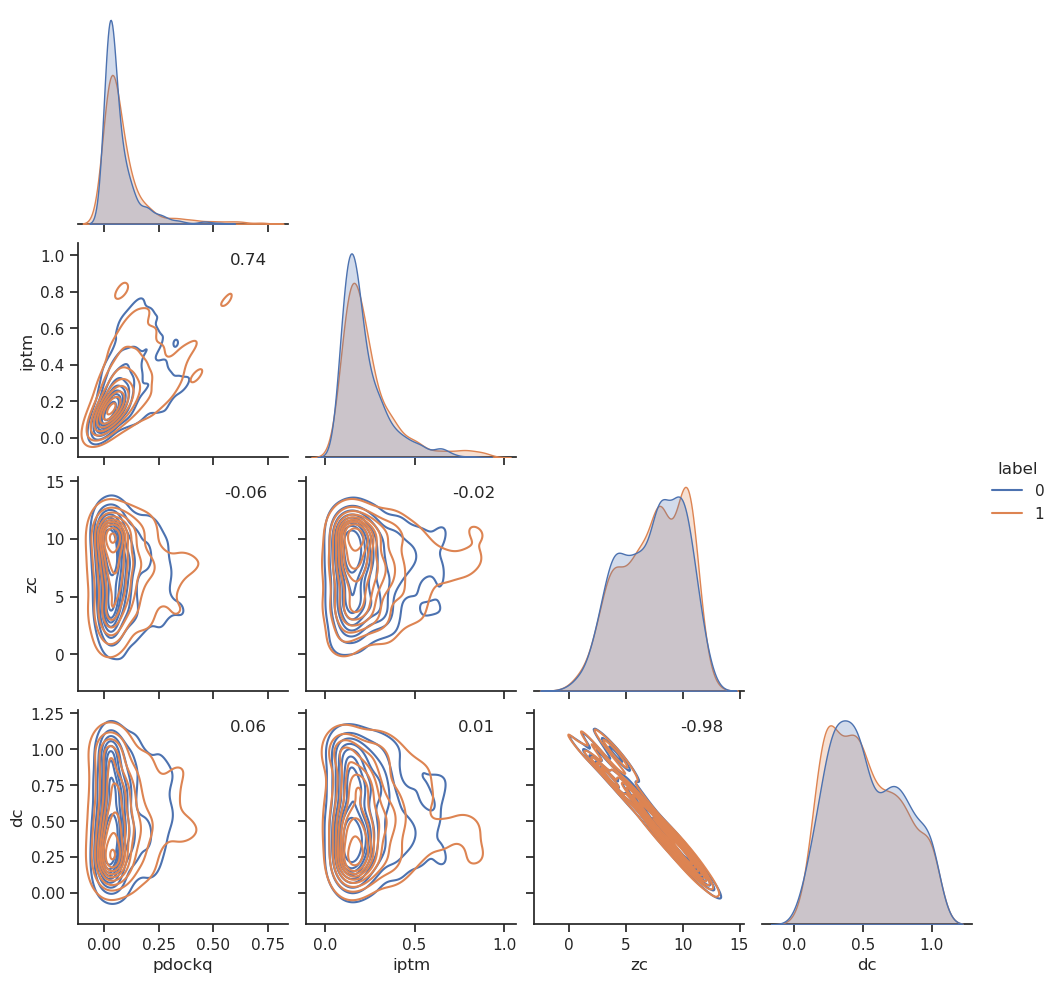

In [218]:
sn = sns.pairplot(data=df[['pdockq',
                           'iptm',
                           'zc', 'dc',
                           'label']],
                  corner=True,
                  kind='kde',
                  hue='label',
                  )
sn.map_lower(corrfunc)

### look at Spearmen

In [219]:
cols = ['pdockq', 'iptm', 'ptm', 'ppv', 'zc', 'dc', 'M0', 'M0x']
for c in cols + ['index', 'chunk']:
    rho = df[c].corr(df.label, method='spearman')
    print(f'{c+ ":": <8} {rho: .3f}')

pdockq:   0.094
iptm:     0.084
ptm:      0.052
ppv:      0.079
zc:       0.024
dc:      -0.030
M0:       0.125
M0x:      0.176
index:   -0.197
chunk:    0.857


### look at individual columns

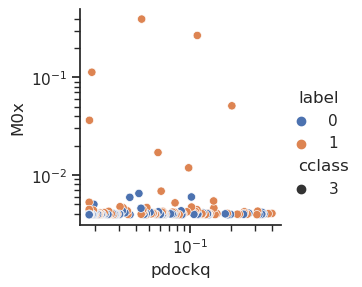

In [225]:
sn = sns.relplot(data=df.loc[(df.cclass == 3)],  # & (df.pdockq > .23)],
                 x='pdockq',
                 y='M0x',
                 hue='label',
                 height=h,
                 style='cclass',
                 facet_kws=dict(sharey=False),
                 )
sn.set(yscale='log', xscale='log')

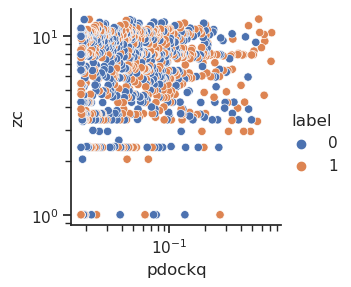

In [305]:
sn = sns.relplot(data=df,
                 x='pdockq',
                 y='zc',
                 hue='label',
                 height=h,
                 # style='cclass',
                 facet_kws=dict(sharey=False),
                 )
sn.set(yscale='log', xscale='log')

'The more "extreme" the lower average Chi-Zod score, the more likely it is to be the significant one out of the pair. Therefore, more of the pairs involving this extreme value fall at this y value, and horizontal lines appear more and more the lower we go in the graph.'

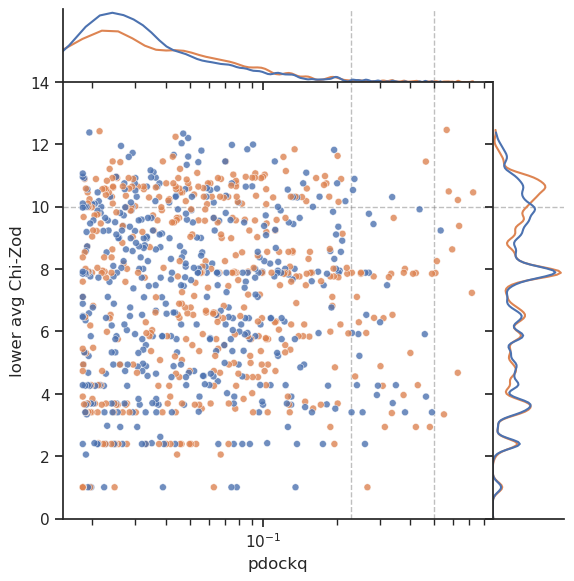

In [341]:
g = sns.JointGrid(data=df,
                  x='pdockq', y='zc',
                  hue='label',
                  marginal_ticks=True, height=2 * h,
                  space=0, ratio=6,
                  )
g.plot_joint(sns.scatterplot, legend=False,
             s=25, alpha=.8, rasterized=True,
             )
# g.plot_marginals(sns.histplot, multiple='fill')
g.plot_marginals(sns.kdeplot, warn_singular=False,
                 cut=0,
                 # multiple='fill',
                 bw_adjust=.2,
                 )
g.ax_marg_x.set(yticks=[])
g.ax_marg_y.set(xticks=[])

g.ax_joint.set(  # xlim=(ratio - 4, ratio + 4),
    ylim=(0, 14),
    # xlim=(.23, None),
    ylabel='lower avg Chi-Zod',
    xscale='log', yscale='linear',
)

g.refline(x=.23, lw=1, alpha=.5, zorder=0)
g.refline(x=.5, lw=1, alpha=.5, zorder=0)
g.refline(y=10, lw=1, alpha=.5, zorder=0)
'The more "extreme" the lower average Chi-Zod score, the more likely it is to be the significant one out of the pair. Therefore, more of the pairs involving this extreme value fall at this y value, and horizontal lines appear more and more the lower we go in the graph.'

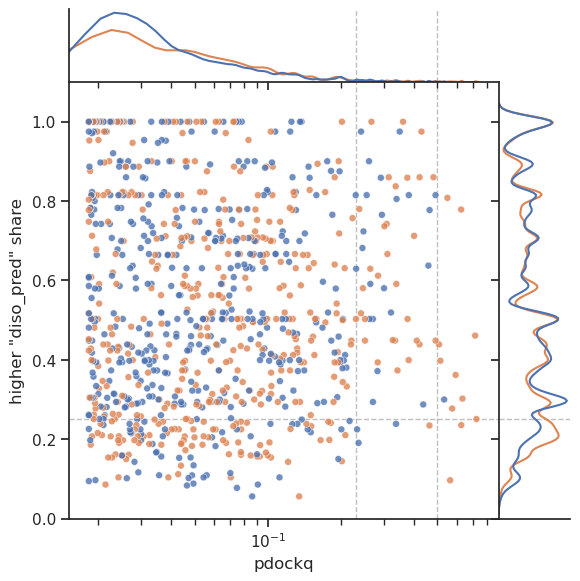

In [347]:
g = sns.JointGrid(data=df,
                  x='pdockq', y='dc',
                  hue='label',
                  marginal_ticks=True, height=2 * h,
                  space=0, ratio=6,
                  )
g.plot_joint(sns.scatterplot, legend=False,
             s=25, alpha=.8, rasterized=True,
             )
g.plot_marginals(sns.kdeplot,
                 bw_adjust=.2,
                 warn_singular=False,
                 )
g.ax_joint.set(  # xlim=(ratio - 4, ratio + 4),
    ylim=(0, 1.1),
    # xlim=(.23, None),
    xscale='log', yscale='linear',
    ylabel='higher "diso_pred" share'
)
g.ax_marg_x.set(yscale='linear', yticks=[])
g.ax_marg_y.set(xticks=[])
g.refline(x=.23, lw=1, alpha=.5, zorder=0)
g.refline(x=.5, lw=1, alpha=.5, zorder=0)
g.refline(y=.25, lw=1, alpha=.5, zorder=0)

### `M0` and `M0x` predictions

In [350]:
dfx = df[['label', 'pdockq', 'M0', 'M0x', 'cclass']].melt(
    id_vars=['label', 'cclass', 'pdockq'])
# dfx = dfx.loc[dfx.cclass == 3]
dfx.head()

,label,cclass,pdockq,variable,value
0,1,2,0.724935,M0,0.013982
1,1,1,0.716168,M0,0.021259
2,1,1,0.635098,M0,0.083882
3,1,1,0.627763,M0,0.001827
4,1,1,0.626991,M0,0.001294


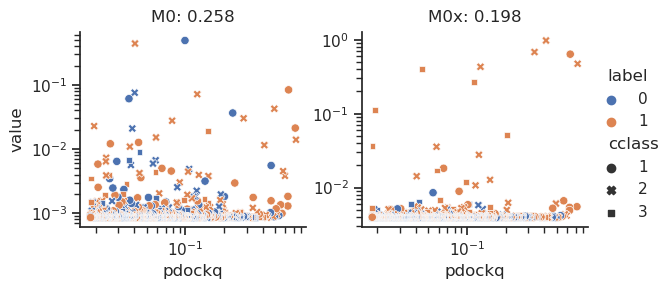

In [352]:
ll = ['M0', 'M0x']
sn = sns.relplot(data=dfx,
                 x='pdockq',
                 y='value',
                 col='variable', col_order=ll,
                 hue='label',
                 height=h,
                 style='cclass',
                 facet_kws=dict(sharey=False),
                 )
sn.set(yscale='log')
sn.set(xscale='log')
sn.set_titles(col_template='')

for ax, method in zip(sn.axes.flatten(), ll):
    rho = spearmanr(df.loc[df.cclass == 3, 'label'],
                    df.loc[df.cclass == 3, method])
    ax.annotate(f'{method}: {rho[0]:.3f}',
                xy=(.5, 1.05),
                xycoords=ax.transAxes,
                ha='center',
                )
# # compare to:
# for method in ['pdockq', 'ppv', 'za', 'zb', 'iptm', 'ptm']:
#     print(f'{method}: {spearmanr(df.label, df[method])[0]:.3f}')

Take a step back!

AF2-m predicts all pairs with a `pdockq > .23 / .5` as PPIs.
How

In [ ]:
mp.sort_values(by='iptm', ascending=False)

In [ ]:
mp.label.value_counts()

In [ ]:
mp.iptm.describe()

In [ ]:
mp.iptm.corr(mp.label, method='spearman')

In [ ]:
ov.ptm.corr(ov.label, method='spearman')

In [ ]:
g = sns.displot(data=ov,
                y='iptm',
                hue='label',
                kind='ecdf',
                height=2.4,
                )
g.set(xlim=(0, 1), ylim=(0, 1))

In [ ]:
g = sns.displot(data=ov,
                x='iptm',
                hue='label',
                height=2.4,
                kind='kde',
                # kind='hist',
                # stat='density',
                # bins=25,
                )
g.set(xlim=(0, 1))

In [ ]:
g = sns.displot(data=ov,
                x='iptm',
                hue='label',
                height=2.4,
                # kind='kde',
                kind='hist',
                stat='density',
                bins=50,
                )
g.set(xlim=(0, 1))

In [ ]:
ev = ov.loc[ov.iptm > .7].copy()
ev.iptm.corr(ev.label, method='spearman')

In [ ]:
g = sns.displot(data=ev,
                x='iptm',
                hue='label',
                height=2.4,
                # kind='kde',
                kind='hist',
                stat='density',
                # bins=15,
                )
# g.set(xlim=(.5, 1))